In [32]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import scipy.stats as stats
from datetime import datetime, timedelta

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [33]:
""" Retrieve Data from yfinance
    :type ticker: string
    :type startDate: string '%Y-%m-%d'
    :type endDate: string '%Y-%m-%d'
    :rtype: pandas dataframe
    -----------------------
    yf.Ticker() -> takes ticker and returns tuple of ticker objects
    .history()  -> returns datafram corresponding to period specified
"""
def pullData(ticker, startDate, endDate):
    return yf.Ticker(ticker).history(start=startDate, end=endDate)

""" Generate a Candlestick Plot
    :type df: pandas dataframe
    :type mav: tuple
    :type ticker: string
"""

""" Return price at a given day
    :type date: str or pandas timestamp
    :type df: pandas dataframe
    :rtype: float
"""  
def getPrice(date, df):
    if df.loc[df.index==date].empty:
        print("ERR: Unable to getPrice(), No trading data for",date)
    return df.loc[df.index==date]['Open'][0]

""" Return all local minimums and maximums for a given timeframe
    :type df: pandas dataframe
    :type start: str or pandas timestamp
    :type end: str or pandas timestamp
    :rtype: dict{date:price}
"""  
def get_Peaks_and_Valleys(df, start, end):
    peaks = {}
    valleys = {}
    
    days = ( pd.to_datetime(end) -  pd.to_datetime(start)).days

    for i in range(0,days,3):    
        startDate = pd.to_datetime(start) + timedelta(i)

        while df.loc[df.index==startDate].empty:
            startDate = startDate + timedelta(1)

        initial_state = state(date=startDate, price=getPrice(startDate, df))

        climb = problem_hillclimb(initial=initial_state, df=df, objective_function=getPrice, stepsize=1)
        out = hill_climb(climb, n_iter=50)
        peaks[out.date] = out.price

        initial_state = state(date=startDate, price=getPrice(startDate, df))
        fall = problem_hillfall(initial=initial_state, df=df, objective_function=getPrice, stepsize=1)
        out = hill_fall(fall, n_iter=50)
        valleys[out.date] = out.price
        
    return peaks, valleys

"""~~~~~~~~~~~ FOR HILLCLIMBING ~~~~~~~~~~~"""

""" Define State of problem as a date and a time """ 
class state:
    def __init__(self, date, price):
        self.date = date
        self.price = price
    
class problem:
    """ Maintain everything that defines the problem
    :type initial_state: Class state
    :type current_state: Class state
    :type objective_function: defined function
    :type stepsize: int
    :type df: pandas dataframe
    """ 
    def __init__(self, initial, df, objective_function, stepsize):
        self.initial_state = initial
        self.current_state = initial
        self.objective_function = objective_function
        self.stepsize = stepsize
        self.df = df
    
    """ Return possible moves to take
    :rtype: array of dates
    """  
    def moves(self):
        all_moves = []
        
        newMoveForward = self.current_state.date + timedelta(self.stepsize)
        newMoveBackward = self.current_state.date - timedelta(self.stepsize)
        
        while df.loc[df.index==newMoveForward].empty:
            newMoveForward = newMoveForward + timedelta(self.stepsize)
        while df.loc[df.index==newMoveBackward].empty:
            newMoveBackward = newMoveBackward - timedelta(self.stepsize)
            
        all_moves.append(newMoveBackward)
        all_moves.append(newMoveForward)
        
        return all_moves
        
""" Performs hill climbing
    :type problem: Class problem
    :type n_iter: int
    :rtype: if peak found: Class state
            if no peak found: False
"""  
def hill_climb(problem, n_iter):
    # for t in some number of iterations:
    #     1. get a list of our available moves
    #     2. which move optimizes the objective function?
    #     3. do that move; update our status
    #     4. possible goal/convergence check
    
    for i in range(n_iter):
        nextMove, nextValue = problem.best_move()
        
        if nextValue <= problem.current_state.price: return problem.current_state
        
        problem.current_state.date, problem.current_state.price = nextMove, nextValue
        
    print("Reached n iterations.")
    return False

class problem_hillclimb(problem):
    """ Choose date that has higher price
    :rtype: datetime, int
    """  
    def best_move(self):
        all_moves = self.moves()
        
        obj_func = [self.objective_function(moves, self.df) for moves in all_moves]
        
        if obj_func[0] > obj_func[1]: return all_moves[0], obj_func[0]
        
        else: return all_moves[1], obj_func[1]
        
""" Performs hill falling
    :type problem: Class problem
    :type n_iter: int
    :rtype: if peak found: Class state
            if no peak found: False
"""          
def hill_fall(problem, n_iter):
    # for t in some number of iterations:
    #     1. get a list of our available moves
    #     2. which move optimizes the objective function?
    #     3. do that move; update our status
    #     4. possible goal/convergence check
    
    for i in range(n_iter):
        nextMove, nextValue = problem.best_move()
        
        if nextValue >= problem.current_state.price: return problem.current_state
    
        problem.current_state.date, problem.current_state.price = nextMove, nextValue
        
    print("Reached n iterations.")
    return False
   
class problem_hillfall(problem):
    """ Choose date that has lower price
    :rtype: datetime, int
    """  
    def best_move(self):
        all_moves = self.moves()
        
        obj_func = [self.objective_function(moves, self.df) for moves in all_moves]
        
        if obj_func[0] < obj_func[1]: return all_moves[0], obj_func[0]

        else: return all_moves[1], obj_func[1]


In [34]:
ticker = 'AAPL'
startDate = '2014-12-01'
endDate = '2016-02-01'

df = pullData(ticker, startDate, endDate)
peaks, valleys = get_Peaks_and_Valleys(df, start='2015-01-01', end='2016-01-01')



In [35]:
##FINDING SUPPORT



def supportFinder():
    ##initialize vector containing all the pertinent support data
    inita = np.array(list([])) 
    initb = np.array(list([]))
    support = np.array(list(zip(inita,initb))) 

    ##initialize the bucket we want to use in our search for support data
    bucket = .01
    bucketItems = {}

    date = np.array(list(valleys.keys())) ## get all the dates from our dictonary result
    price = np.array(list(valleys.values())) ##get all the prices from our dictionary result
    z = np.array(list(zip(date,price))) ##zip as a 2d array
   


    for x in range(len(z)): ## for all values with index 0 to range(valleys)
        
        for y in range(x-1): ## for all values with index 0 to 

                if (abs ( (z[y][1]-z[x][1])  / (z[x][1]) ) < bucket): 
                        
                    
                        l = 0
                        counter = 0 
                        bucketFound = False 
                        
                        if(len(support) ==0):
                                    g = np.append(support, [z[x]]) 
                                    support = g
                                    tempVal = {}
                                    tempVal[z[x][0]]=z[x][1]
                                    bucketItems[z[x][1]]=[]
                                    bucketItems[z[x][1]].append(tempVal)
                        
                        for i in support:
                            
                            
                            if(counter%2==1):
                                
                                
                                
                                if (abs ( (i-z[x][1])  / (i) ) < bucket):
                                    
                                    bucketFound = True 
                                    tempVal = {}
                                    tempVal[z[x][0]]=z[x][1]
                                    
                                    if(tempVal not in bucketItems[i] ):
                                        bucketItems[i].append(tempVal)

                                    
                            counter = counter+1
                        
                        
                        if(bucketFound == False):
                            if(z[x] not in support):
                                g = np.append(support, [z[x]]) 
                                support = g
                                
                            tempVal = {}
                            tempVal[z[x][0]]=z[x][1]
                            
                            if(tempVal not in bucketItems.values() ):
                                bucketItems[z[x][1]]=[]
                                bucketItems[z[x][1]].append(tempVal)
                        
                           
                            
                        
                            
                            
    return support,bucketItems
                        


In [36]:


s,b = supportFinder()
print("SUPPORT VALUES")
print(len(s))


supportDates= []
supportVals = []
counter22 = 0
counter20 = 0 
for i in s:
    if (counter22%2==0):
        supportDates.append(i)
    if(counter22%2 == 1):
        supportVals.append(i)
    counter22 = counter22+1
        
print(b.keys())
print(s)
#print(s)


SUPPORT VALUES
26
dict_keys([24.18, 27.84, 28.13, 28.54, 29.24, 29.57, 28.85, 25.74, 26.15, 24.5, 25.2, 26.96, 26.49])
[Timestamp('2015-01-16 00:00:00') 24.18 Timestamp('2015-03-26 00:00:00')
 27.84 Timestamp('2015-03-30 00:00:00') 28.13
 Timestamp('2015-04-09 00:00:00') 28.54 Timestamp('2015-05-18 00:00:00')
 29.24 Timestamp('2015-06-02 00:00:00') 29.57
 Timestamp('2015-06-09 00:00:00') 28.85 Timestamp('2015-08-12 00:00:00')
 25.74 Timestamp('2015-08-14 00:00:00') 26.15
 Timestamp('2015-08-26 00:00:00') 24.5 Timestamp('2015-09-01 00:00:00')
 25.2 Timestamp('2015-11-24 00:00:00') 26.96
 Timestamp('2015-12-04 00:00:00') 26.49]


<ipython-input-35-375136f626a6>:61: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(z[x] not in support):


In [37]:
def resistanceFinder():
    

    ##initialize vector containing all the pertinent support data
    inita = np.array(list([]))
    initb = np.array(list([]))
    resistance = np.array(list(zip(inita,initb)))

    ##initialize the bucket we want to use in our search for support data
    bucket = .01
    
    bucketItems = {}

    date = np.array(list(peaks.keys())) ## get all the dates from our dictonary result
    price = np.array(list(peaks.values())) ##get all the prices from our dictionary result
    z = np.array(list(zip(date,price))) ##zip as a 2d array
   
    for x in range(len(z)):
        for y in range(x-1):

                if (abs ( (z[y][1]-z[x][1])  / (z[x][1]) ) < bucket): 
                    
                        l = 0
                        counter = 0 
                        bucketFound = False 
                        
                        if(len(resistance) ==0):
                                    g = np.append(resistance, [z[x]]) 
                                    resistance = g
                                    tempVal = {}
                                    tempVal[z[x][0]]=z[x][1]
                                    bucketItems[z[x][1]]=[]
                                    bucketItems[z[x][1]].append(tempVal)
                                    
                        
                        for i in resistance:
#                             print(i)
#                             print(bucketItems)
                            
                            
                            if(counter%2==1):
                               
                                
                                if (abs ( (i-z[x][1])  / i ) < bucket):
                                    bucketFound = True 
                                    tempVal = {}
                                    tempVal[z[x][0]]=z[x][1]
                                    
                                    if(tempVal not in bucketItems[i] ):
                                        bucketItems[i].append(tempVal)
                                    

                                    
                            counter = counter+1
                        
                        
                        if(bucketFound == False):
                            if(z[x] not in resistance):
                                g = np.append(resistance, [z[x]]) 
                                resistance = g
                            
                            tempVal = {}
                            tempVal[z[x][0]]=z[x][1]
                            
                            if(tempVal not in bucketItems.values() ):
                                bucketItems[z[x][1]]=[]
                                bucketItems[z[x][1]].append(tempVal)
                                
                           
                        
                        
                        
                
                          
    return resistance, bucketItems






                
                        

                        
                        
                            
                            
                           
                                
                                

In [38]:
r,b = resistanceFinder()
resistanceDates= []
resistanceVals = []
counter22 = 0
counter20 = 0 
for i in r:
    if (counter22%2==0):
        resistanceDates.append(i)
    if(counter22%2 == 1):
        resistanceVals.append(i)
    counter22 = counter22+1
        


<ipython-input-37-0593ac624d83>:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(z[x] not in resistance):


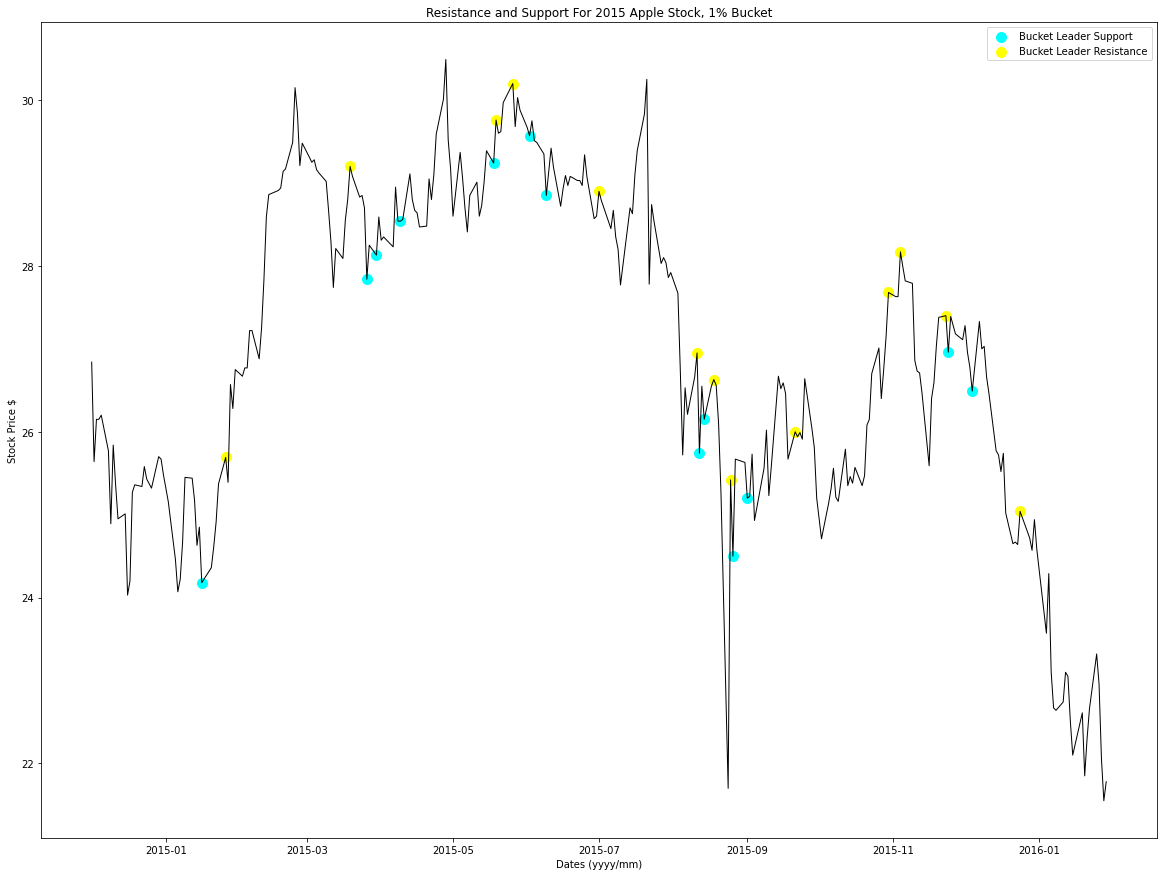

In [39]:
fig, ax = plt.subplots(figsize=(20,15))

ax.scatter(supportDates,supportVals,color='cyan',s=100, label = "Bucket Leader Support")
ax.scatter(resistanceDates,resistanceVals,color='yellow',s=100, label = "Bucket Leader Resistance")

ax.plot(df.index,df['Open'],color='black',lw=1)
plt.title("Resistance and Support For 2015 Apple Stock, 1% Bucket")
plt.xlabel("Dates (yyyy/mm)")
plt.ylabel("Stock Price $")

plt.legend()

plt.show()

In [41]:
import math
def findNearestSupport(day,value,s, supportDates, supportVals):
        
    nearestDate = 0
    nearestVal = 0
    for x in supportDates:
        nearestDate = x
    
    for y in supportVals:
        nearestVal = y
    if(nearestDate == 0):
        nearestDate = supportDates[0]
    euclideanDistance = math.sqrt(((nearestDate - day).days**2)+ ((nearestVal - value)**2))
    return euclideanDistance

def findNearestResistance(day,value,s, resistanceDates, resistanceVals):
    nearestDate = 0
    nearestVal = 0
    for x in resistanceDates:
        nearestDate = x
    
    for y in resistanceVals:
        nearestVal = y
    
    if(nearestDate == 0):
        nearestDate = resistanceDates[0]
     
    
    euclideanDistance = math.sqrt(((nearestDate - day).days**2)+ ((nearestVal - value)**2))
    return euclideanDistance
    
        
    
    

In [42]:
def EuclideanDistanceFinder(s,r):
    
    
     ## get all the dates from our dictonary result
    
    supportDates= []
    supportVals = []
    counter22 = 0
    counter20 = 0 
    for i in s:
        if (counter22%2==0):
            supportDates.append(i)
        if(counter22%2 == 1):
            supportVals.append(i)
        counter22 = counter22+1
        

        
    
    resistanceDates= []
    resistanceVals = []
    counter22 = 0
    counter20 = 0 
    
    for i in r:
        if (counter22%2==0):
            resistanceDates.append(i)
        if(counter22%2 == 1):
            resistanceVals.append(i)
        counter22 = counter22+1
        
  
    
    
    ResandSup= {}

    for x in df.index:
        valueForDay = df.loc[df.index==x]['Open'][0]
        
        euclidSup = findNearestSupport(x,valueForDay,s, supportDates, supportVals)
        euclidRes = findNearestResistance(x,valueForDay,s, resistanceDates, resistanceVals)
        
        ResandSup[x] = [euclidSup,euclidRes]
        

    return ResandSup
        
   
    
    

In [47]:
euclid = EuclideanDistanceFinder(s,r)
for i in euclid:
    print(str(i) +": " + str(euclid[i]))

2014-12-01 00:00:00: [368.0001664401797, 388.00417523526727]
2014-12-02 00:00:00: [367.00098433110503, 387.00046511599953]
2014-12-03 00:00:00: [366.0001579234632, 386.0015959811565]
2014-12-04 00:00:00: [365.00015835613004, 385.00160012654493]
2014-12-05 00:00:00: [364.0001155219597, 384.0017520793362]
2014-12-08 00:00:00: [361.0007180048261, 381.00069934319015]
2014-12-09 00:00:00: [360.00355553799744, 380.000029605262]
2014-12-10 00:00:00: [359.00058843962915, 379.0008443262363]
2014-12-11 00:00:00: [358.00178337544634, 378.0001354497112]
2014-12-12 00:00:00: [357.00332155317545, 377.0000107427054]
2014-12-15 00:00:00: [354.0030937717918, 374.00000120320857]
2014-12-16 00:00:00: [353.0085715673205, 373.00136742376696]
2014-12-17 00:00:00: [352.0074489268657, 372.00094838588785]
2014-12-18 00:00:00: [351.00212022151663, 371.0000712937937]
2014-12-19 00:00:00: [350.0018241381036, 370.0001383783525]
2014-12-22 00:00:00: [347.00190561436403, 367.0001226157833]
2014-12-23 00:00:00: [346.